In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from math import *

# Using PyTorch to run the evolutionary simulations in parallel on the GPU
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Parameter
import torch.optim
from torch.autograd import Variable

import IPython.display as display
import time

import copy

# For fast conversion between NumPy and PyTorch on GPU
def tovar(x):
    return torch.FloatTensor(x).cuda()

def toivar(x):
    return torch.LongTensor(x).cuda()

In [2]:
# Instantiates a batch of evolutionary simulations. 
#
# pop - Population size 
# geno_size - Length of the genome
# Nsys - Number of simulations in the batch
# fraction - Corresponds to $\Gamma$ in the paper, this is how many bits on average are coding in a given environment

class EvoSystem():
    def __init__(self, pop=200, geno_size = 20, Nsys = 1000, fraction = 0.5):
        # Initialize a random environment vector and mask vector
        self.target = tovar(np.random.randint(2, size=(Nsys, geno_size)))
        self.target_mask = tovar(1*(np.random.rand(Nsys, geno_size)<fraction))
        
        # Start the population with all organisms at a particular random binary string
        self.population = torch.randint(2, (Nsys, 1, geno_size)).cuda().float()
        self.population = self.population.expand(Nsys, pop, geno_size)
        
        self.geno_size = geno_size
        self.fraction = fraction
    
    # Generate a new environment
    def new_env(self):
        self.target = tovar(np.random.randint(2, size=(self.target.size(0), self.geno_size)))
        self.target_mask = tovar(1*(np.random.rand(self.target.size(0), self.geno_size)<self.fraction))
    
    # Generate mutations of a population 'x' with per-base mutation rate mu
    def mutate(self, x, mu):
        # Each base in each organism has a random number uniformly drawn from [0,1]
        moves = torch.zeros(x.size(0), x.size(1), x.size(2)).cuda()
        moves.uniform_()
        
        # This is then compared against the mutation rate to give a mask for where mutations occur
        moves = torch.le(moves, mu).float()
        
        # Where mutations occur, the base is flipped. Otherwise it's the same.
        x = (1-moves)*x + moves*(1-x)
        
        return x
    
    # Evaluate the fitness of each organism in the population
    def fitness(self):
        # Find how many coding bits are different than the target in each organism
        err = (self.target_mask.unsqueeze(1)*torch.abs(self.population-self.target.unsqueeze(1))).sum(2)
        
        # The fitness is 1 + coding length - differences
        maxfit = torch.sum(self.target_mask.unsqueeze(1),2)
        matches = maxfit - err
        
        return 1+matches
    
    # Step the population once with per-base mutation rate mu
    def step(self, mu = 0):
        # Get the fitnesses of the current generation
        fitness = self.fitness()
        
        # The new generation is created by sampling from the current generation proportional to fitness,
        # with replacement. So something with a fitness 2 has twice the chance of filling a given spot in the
        # next generation as something with a fitness 1.
        #
        # Multinomial gets us the indices of the parents for each child spot
        pop_idx = torch.multinomial(fitness, self.population.size(1), replacement=True)
        
        # Then we gather those parents from the current generation to make the new generation
        pop_idx = pop_idx.unsqueeze(2)
        pop_idx = pop_idx.expand(pop_idx.size(0), pop_idx.size(1), self.geno_size)
        newpop = torch.gather(self.population, 1, pop_idx)
        
        # Finally, we mutate the new generation and replace the old
        self.population = self.mutate(newpop, mu)
        
        return torch.mean(fitness).cpu().detach().item()

In [3]:
# This is the main control code for the simulations. It takes the parameters and returns aggregated
# data from 5000 runs at those parameters
#
# geno_size - Length of the genome
# gens - Total number of generations to simulate in the run
# pop - Population size
# mu - Total mutation rate (expected mutations per generation per organism). This is converted internally to
#      mutations per base
# fraction - $\Gamma$ parameter, environment information size
# period - How frequently to oscillate between the environments. 
#       period = gens/2 is used for the 'slow' runs, while period=1 is used for the 'fast' runs

def getData(geno_size=50, gens = 400, pop = 50, mu=0.1, fraction = 0.5, period = 20):
    Nsys = 1000
    
    # We aren't going to use backprop, so this saves us some memory and computation
    with torch.no_grad():
        # Initialize storage for the results
        ys1 = np.zeros((0, geno_size))
        ysm1 = np.zeros((0, geno_size))
        ys2 = np.zeros((0, geno_size))
        ysm2 = np.zeros((0, geno_size))
        xs = np.zeros((0, geno_size, gens))
        fits = np.zeros((gens))
        
        # Do 5000 runs total
        for j in range(5000//Nsys):
            evo = EvoSystem(pop = pop, geno_size = geno_size, Nsys = Nsys, fraction = fraction)
            
            # Burn in period to make a population distributed according to the mutation dynamics
            for i in range(200):
                evo.step(mu=mu/geno_size)
            
            # Set up the two environments we care about and record them in ys1 and ys2 (targets), ysm1 and ysm2 (masks)
            evo.new_env()
            e2 = evo.target.detach()
            e2m = evo.target_mask.detach()
            ys2 = np.concatenate([ys2, evo.target.cpu().detach().numpy()], axis=0)
            ysm2 = np.concatenate([ysm2, evo.target_mask.cpu().detach().numpy()], axis=0)

            evo.new_env()
            e1 = evo.target.detach()
            e1m = evo.target_mask.detach()
            ys1 = np.concatenate([ys1, evo.target.cpu().detach().numpy()], axis=0)
            ysm1 = np.concatenate([ysm1, evo.target_mask.cpu().detach().numpy()], axis=0)            
            
            seq = np.zeros((Nsys, geno_size, 0))
            
            # Step through the simulations
            j = 0
            for i in range(gens):
                f = evo.step(mu=mu/geno_size)
                fits[i] += f/(5000/Nsys)
                
                # Switch environments every period steps
                if i%period == period-1:
                    if j == 0:
                        evo.target = e2
                        evo.target_mask = e2m
                        j = 1
                    else:
                        evo.target = e1
                        evo.target_mask = e1m
                        j = 0
                
                # Record the fraction of 1s at each base in the population
                population = evo.population.cpu().detach().numpy()                    
                pmu = np.mean(population[:,:,:],axis=1).reshape((Nsys, geno_size, 1))
                seq = np.concatenate([seq, pmu], axis=2)
                                                        
            xs = np.concatenate([xs, seq], axis=0)

    return xs, ys1, ysm1, ys2, ysm2, fits

In [4]:
# Calculate the per-base mutual information via direct sampling
# xs - Set of population histograms at a point in time
# ys - Environmental vectors to check against corresponding to the populations in xs
# ym - Environmental masks

def fastMI(xs, ys, ym, BINS = 100):
    lMI = 0
    
    for i in range(xs.shape[1]):
        # Accumulate p(x), p(y), and p(x,y)
        py = np.zeros(2) + 1e-64
        
        mask = ym[:,i]==1
        xsm = np.clip(xs[mask,i]*BINS,0,BINS-1).astype(np.int32)
        ysm = ys[mask,i].astype(np.int32)
        
        px, _ = np.histogram(xsm, bins=BINS)
        pxy, _, _ = np.histogram2d(xsm, ysm, bins=[BINS,2])
        px = px + 1e-64
        pxy = pxy + 1e-64
        py[1] = np.mean(ys) + 1e-64
        py[0] = 1-py[1] + 1e-64
        
        py = py/np.sum(py)
        px = px/np.sum(px)
        pxy = pxy/np.sum(pxy)
        
        # Add to the mutual information per base
        lMI += np.sum( pxy * np.log(pxy / (px[:,np.newaxis] * py[np.newaxis,:]))) / xs.shape[1]
    return lMI

In [7]:
# Save mutual information trajectories for a given set of parameters mu, $\Gamma$, and period
def getMIs(mu = 0.5, fraction = 0.5, period = 200, pop=200, doPop=False):
    GENS = 400
    
    xs, ys1, ysm1, ys2, ysm2, fits = getData(gens=GENS, geno_size=50, pop=pop, mu=mu, fraction = fraction, period = period)
    T = []
    MI = []
    MI2 = []

    for t in range(0,GENS-1,1):
        T.append(t)
        MI.append(fastMI(xs[:,:,t], ys1, ysm1))
        MI2.append(fastMI(xs[:,:,t], ys2, ysm2))

        plt.clf()

        plt.plot(T,MI)
        plt.plot(T,MI2)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)    
    
    T = np.array(T)
    T = T.reshape((T.shape[0], 1))
    
    maxMI = np.log(2)
    MI = np.array(MI).reshape((T.shape[0], 1))/maxMI
    MI2 = np.array(MI2).reshape((T.shape[0], 1))/maxMI
    fits = fits[:-1].reshape((T.shape[0], 1))
    data = np.concatenate([T,MI,MI2,fits], axis=1)
    
    # Save results in the appropriate directory for analysis
    if doPop == False:
        if period == 200:
            np.savetxt("results/%.3f_%.3f.txt" % (mu, fraction), data)
        else:
            np.savetxt("results_oscillate/%.3f_%.3f.txt" % (mu, fraction), data)
    else:
        if period == 200:
            np.savetxt("results/P%d.txt" % (pop), data)
        else:
            np.savetxt("results_oscillate/P%d.txt" % (pop), data)        

## Slow variation simulations - $\mu$

In [ ]:
mus = [x for x in np.arange(0.1, 2.1, 0.1)] + [2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.6, 6.0, 6.4]

for x in mus:
    getMIs(mu = x, fraction = 0.2, period = 200)

## Slow variation simulations - $\Gamma$

In [ ]:
fracs = np.arange(0.05, 1.05, 0.05)

for x in fracs:
    getMIs(mu = 0.5, fraction = x, period = 200)

## Fast variation simulations - $\mu$

In [ ]:
mus = [x for x in np.arange(0.1, 2.1, 0.1)] + [2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.6, 6.0, 6.4]

for x in mus:
    getMIs(mu = x, fraction = 0.2, period = 1)

## Fast variation simulations - $\Gamma$

In [ ]:
fracs = np.arange(0.05, 1.05, 0.05)

for x in fracs:
    getMIs(mu = 0.5, fraction =x, period = 1)

## Population variation

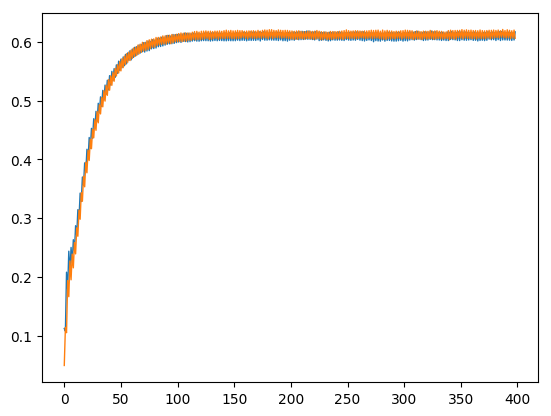

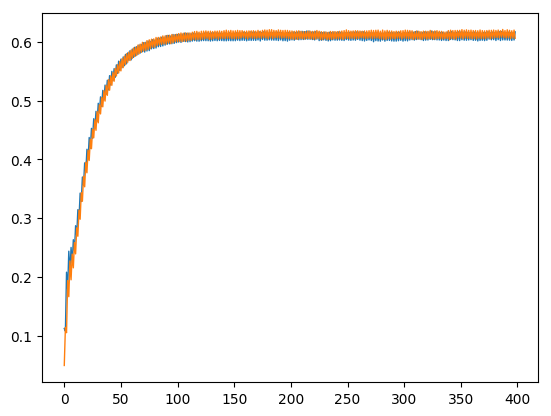

In [8]:
pops = [10,20,30,40,60,80,100,120,140,160,180,200,280,320,400,500,600,800,1000]

for p in pops:
    getMIs(mu = 0.5, fraction = 0.2, period = 200, pop=p, doPop=True)
    getMIs(mu = 0.5, fraction = 0.2, period = 1, pop=p, doPop=True)